In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic_real_dynamic import create_true, create_full_cadence, create_false, create_true_single_shot, create_true_faster
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import math
from sklearn.metrics import silhouette_score
import sys
sys.path.insert(1, '../ML_Training')
sys.path.insert(2, '../GBT_pipeline')
from preprocess_dynamic import get_data
from single_search import search_model_eval, combine
from skimage.transform import rescale, resize, downscale_local_mean
import gc
from keras.regularizers import l1, l2
from data_generation import create_data_set
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/pma/.local/lib/python3.6/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
plate1 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP110750.npy')[8000:]
plate2 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP13402.npy')[8000:]
plate3 = np.load('../../../../../../../datax/scratch/pma/real_filtered_LARGE_HIP8497.npy')[8000:]
plate = np.vstack([plate1, plate2, plate3])
del plate1, plate2, plate3 
gc.collect()
print(plate.shape)

(19701, 6, 16, 4096)


In [3]:
%matplotlib inline
NUM_SAMPLES = 2
data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1)

Creating True
(2, 6, 16, 4096)
(2, 6, 16, 4096) (2, 6, 16, 512)
(2, 6, 16, 512)
(12, 16, 512, 1)
Creating False
(12, 6, 16, 4096) (12, 6, 16, 512)
(12, 6, 16, 512)
Creating True
(6, 6, 16, 4096) (6, 6, 16, 512)
(6, 6, 16, 512)
(6, 6, 16, 4096) (6, 6, 16, 512)
(6, 6, 16, 512)
(12, 6, 16, 512, 1)


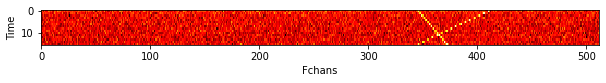

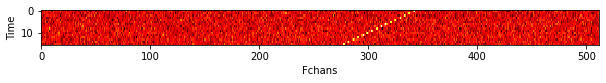

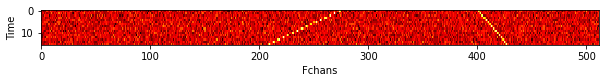

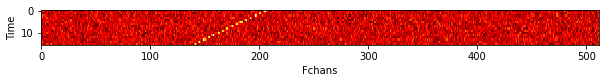

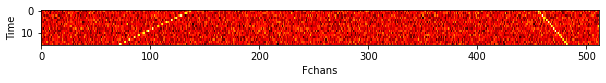

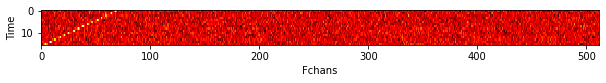

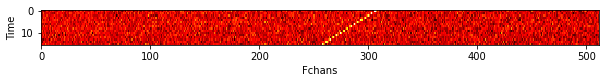

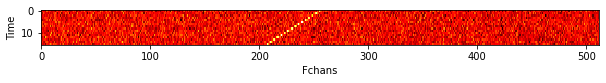

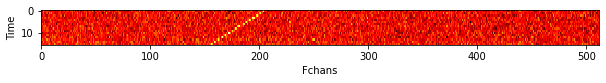

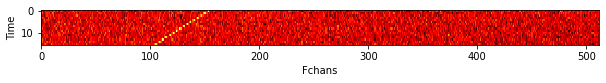

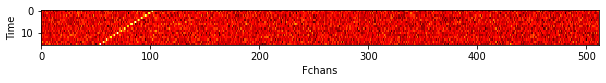

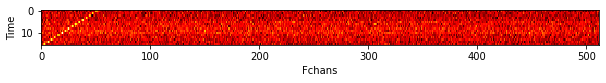

In [4]:
for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[0,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

for i in range(6):
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(true_data[1,i,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'), aspect=2)
    plt.show()

In [5]:
NUM_SAMPLES = 2
data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=20, snr_range = 10, factor=1)

Creating True
(2, 6, 16, 4096)
(2, 6, 16, 4096) (2, 6, 16, 512)
(2, 6, 16, 512)
(12, 16, 512, 1)
Creating False
(12, 6, 16, 4096) (12, 6, 16, 512)
(12, 6, 16, 512)
Creating True
(6, 6, 16, 4096) (6, 6, 16, 512)
(6, 6, 16, 512)
(6, 6, 16, 4096) (6, 6, 16, 512)
(6, 6, 16, 512)
(12, 6, 16, 512, 1)


In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha=10, beta=2, gamma = 10, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.true_loss_tracker = keras.metrics.Mean(name="true_loss")
        self.false_loss_tracker = keras.metrics.Mean(name="false_loss")
        
        self.true_score_tracker = keras.metrics.Mean(name="true_score")
        self.false_score_tracker = keras.metrics.Mean(name="false_score")
        
        
        self.total_loss_tracker_validation = keras.metrics.Mean(name="val_total_loss")
        self.reconstruction_loss_tracker_validation = keras.metrics.Mean(
            name="val_reconstruction_loss"
        )
        self.kl_loss_tracker_validation = keras.metrics.Mean(name="val_kl_loss")
        self.false_loss_tracker_validation = keras.metrics.Mean(name="val_false_loss")
        self.true_loss_tracker_validation = keras.metrics.Mean(name="val_true_loss")
        
        self.true_score_tracker_validation = keras.metrics.Mean(name="true_score")
        self.false_score_tracker_validation = keras.metrics.Mean(name="false_score")
        
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.count=1

    @tf.function
    def loss_diff(self, a,b):
        return 1/ self.loss_same(a,b)
   
    @tf.function
    def loss_same(self, a,b):
        return tf.math.reduce_mean(tf.math.reduce_euclidean_norm(a-b, axis=1))

    
    @tf.function
    def true_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += (difference - same)/same
        else:
            similarity += (difference - same)/difference
 
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def false_score(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        same+= self.loss_same(a1,a2)
        same+= self.loss_same(a1,a3)
        
        same+= self.loss_same(a2,a1)
        same+= self.loss_same(a2,a3)
        
        same+= self.loss_same(a3,a2)
        same+= self.loss_same(a3,a1)
        
        same+= self.loss_same(b,c)
        same+= self.loss_same(b,d)
        
        same+= self.loss_same(c,b)
        same+= self.loss_same(c,d)
        
        same+= self.loss_same(d,b)
        same+= self.loss_same(d,c)
        
        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)
        
        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)
        
        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)
        
        if same > difference:
            similarity += -(difference - same)/same
        else:
            similarity += -(difference - same)/difference
        
        return 10*(1-similarity)/(2*(similarity+1))
    
    @tf.function
    def true_clustering(self, true_data,training=True):
        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(true_data[:,0,:,:,:], training)[2]
        b = self.encoder(true_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(true_data[:,2,:,:,:],training)[2]
        c = self.encoder(true_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(true_data[:,4,:,:,:], training)[2]
        d = self.encoder(true_data[:,5,:,:,:], training)[2]

        difference += self.loss_diff(a1,b)
        difference += self.loss_diff(a1,c)
        difference += self.loss_diff(a1,d)

        difference += self.loss_diff(a2,b)
        difference += self.loss_diff(a2,c)
        difference += self.loss_diff(a2,d)

        difference += self.loss_diff(a3,b)
        difference += self.loss_diff(a3,c)
        difference += self.loss_diff(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        

        similarity += same+difference
        return similarity
    
    @tf.function
    def false_clustering(self, false_data, training=True):

        similarity = 0
        difference = 0
        same = 0
        a1 = self.encoder(false_data[:,0,:,:,:], training)[2]
        b = self.encoder(false_data[:,1,:,:,:], training)[2]
        a2 = self.encoder(false_data[:,2,:,:,:],training)[2]
        c = self.encoder(false_data[:,3,:,:,:], training)[2]
        a3 = self.encoder(false_data[:,4,:,:,:], training)[2]
        d = self.encoder(false_data[:,5,:,:,:], training)[2]

        difference += self.loss_same(a1,b)
        difference += self.loss_same(a1,c)
        difference += self.loss_same(a1,d)

        difference += self.loss_same(a2,b)
        difference += self.loss_same(a2,c)
        difference += self.loss_same(a2,d)

        difference += self.loss_same(a3,b)
        difference += self.loss_same(a3,c)
        difference += self.loss_same(a3,d)

        same += self.loss_same(a1,a2)
        same += self.loss_same(a1,a3)
        same += self.loss_same(a2,a3)
        
        same += self.loss_same(b,c)
        same += self.loss_same(c,d)
        same += self.loss_same(b,d)
        
        similarity += same+difference
        return similarity
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        self.count+=1
        cluster_loss =0
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )/(16*512)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            false_loss = self.false_clustering(false_data)
            true_loss = self.true_clustering(true_data)
            
#             false_score = self.false_score(false_data)
#             true_score = self.true_score(true_data)
            false_score =0
            true_score = 0
            
            total_loss = reconstruction_loss/(16*256) + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.false_loss_tracker.update_state(false_loss)
        self.true_loss_tracker.update_state(true_loss)
        
        self.false_score_tracker.update_state(false_score)
        self.true_score_tracker.update_state(true_score)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "false_loss": self.false_loss_tracker.result(),
            "true_loss": self.true_loss_tracker.result(),
            "false_score": self.false_score_tracker.result(),
            "true_score": self.true_score_tracker.result()
        }
    

    def test_step(self, data):
        # Unpack the data
        x, y = data
        true_data = x[1]
        false_data = x[2]
        x= x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstruction = self.decoder(z, training=False)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
            )
        )/(16*512)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        false_loss = self.false_clustering(false_data, False)
        true_loss = self.true_clustering(true_data, False)
#         false_score = self.false_score(false_data)
#         true_score = self.true_score(true_data)
        false_score = 0
        true_score =0
        total_loss = reconstruction_loss + self.beta*kl_loss +self.alpha*(1*true_loss+false_loss)+self.gamma*(false_score+true_score)
        
        
        self.total_loss_tracker_validation.update_state(total_loss)
        self.reconstruction_loss_tracker_validation.update_state(reconstruction_loss)
        self.kl_loss_tracker_validation.update_state(kl_loss)
        self.false_loss_tracker_validation.update_state(false_loss)
        self.true_loss_tracker_validation.update_state(true_loss)
        
        self.false_score_tracker_validation.update_state(false_score)
        self.true_score_tracker_validation.update_state(true_score)
        
        return {
            "loss": self.total_loss_tracker_validation.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker_validation.result(),
            "kl_loss": self.kl_loss_tracker_validation.result(),
            "false_loss": self.false_loss_tracker_validation.result(),
            "true_loss": self.true_loss_tracker_validation.result(),
            "false_score": self.false_score_tracker_validation.result(),
            "true_score": self.true_score_tracker_validation.result()
        }

In [7]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_model(latent_dim=8,dens_lay=512, kernel=(3,3), alpha=10, beta=2, gamma=10):
    
    encoder_inputs = keras.Input(shape=(16, 512, 1))
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5, activity_regularizer=l1(0.001))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean", activity_regularizer=l1(0.001),
                          kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var" , activity_regularizer=l1(0.001),
                             kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu", activity_regularizer=l1(0.001), 
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(latent_inputs)
#     x = layers.Dropout(0.5)(x)
    x = layers.Dense(1* 32 * 256, activation="relu", activity_regularizer=l1(0.001),
                     kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
#     x = layers.Dropout(0.5)(x)
    x = layers.Reshape((1,32, 256))(x)
    x = layers.Conv2DTranspose(256, kernel, activation="relu", strides=2,padding="same")(x)
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder, alpha, beta, gamma)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

alpha, beta, gamma = 100,2,0
latent_dim=8
dens_lay=1024
kernel=(3,3)


model_num = 1
name = "VAE-BLPC1-ENCODER_compressed_512v%d"%(model_num)
print(name)

print("Model " +name+": \(\\alpha : %3d\),  \(\\beta : %3d\),  \(\gamma : %3d\), latent_dim:%3d, dense:%3d " % (alpha, beta, gamma, latent_dim, dens_lay))

with strategy.scope():
    model = build_model(latent_dim,dens_lay, kernel, alpha, beta, gamma)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
VAE-BLPC1-ENCODER_compressed_512v1
Model VAE-BLPC1-ENCODER_compressed_512v1: \(\alpha : 100\),  \(\beta :   2\),  \(\gamma :   0\), latent_dim:  8, dense:1024 
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 512, 1)] 0                                            
___________________________

tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
tensorflow      INFO     Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/d

In [11]:
def plot_model(history, name, i):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))

    fig.suptitle("Model v%3d: alpha:%3d, beta:%3d, gamma:%3d, latent_dim:%3d, dense:%3d " % (model_num, alpha, beta, gamma, latent_dim, dens_lay))

    ax1.plot(history.history['false_loss'])
    ax1.plot(history.history['true_loss'])
    ax1.plot(history.history['val_false_loss'])
    ax1.plot(history.history['val_true_loss'])
    ax1.set_title('Model Clustering Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['false_loss', 'true_loss','val_false_loss','val_true_loss'], loc='upper right')
    ax1.grid()

    ax2.plot(history.history['false_score'])
    ax2.plot(history.history['true_score'])
    ax2.plot(history.history['val_false_score'])
    ax2.plot(history.history['val_true_score'])
    ax2.set_title('Model Clustering Score')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['false_score', 'true_score','val_false_score','val_true_score'], loc='upper right')
    ax2.grid()

    ax3.plot(history.history['reconstruction_loss'])
    ax3.plot(history.history['val_reconstruction_loss'])
    ax3.set_title('Model Reconstruction')
    ax3.set_ylabel('loss')
    ax3.set_xlabel('epoch')
    ax3.legend(['reconstruction_loss', 'val_reconstruction_loss'], loc='upper right')
    ax3.grid()

    ax4.plot(history.history['kl_loss'])
    ax4.plot(history.history['val_kl_loss'])
    ax4.set_title('Model Divergence')
    ax4.set_ylabel('loss')
    ax4.set_xlabel('epoch')
    ax4.legend(['kl_loss', 'val_kl_loss'], loc='upper right')
    ax4.grid()
    fig.savefig(name+"-"+str(i)+'.png')

In [ ]:
BATCH= 10
NUM_SAMPLES = 6000
epoch=[100,100,50, 50, 50,50,50,50, 50, 50]
snr_bases_list = [10,10,10,10,10,10,10,10,10,10]
for i in range(BATCH):
    print(i)
    start = time.time()
    data, false_data, true_data = create_data_set(plate, NUM_SAMPLES=NUM_SAMPLES, snr_base=snr_bases_list[i], snr_range = 20, factor=1)
    data_test, false_data_test, true_data_test = create_data_set(plate, NUM_SAMPLES=1000, snr_base=snr_bases_list[i], snr_range = 20, factor=1)
    print(time.time()-start)
    history = model.fit(x = [data, true_data, false_data], y= data[:,:,:,:], epochs=epoch[i], batch_size=2000, 
          validation_data=([data_test, true_data_test, false_data_test ], data_test),validation_batch_size=6000)
    
    del data, false_data, true_data
    gc.collect()
    model.encoder.save(name+"-"+str(i)+".h5")
    plot_model(history, name, i)

0
Creating True
(6000, 6, 16, 4096)
(6000, 6, 16, 4096) (6000, 6, 16, 512)
(6000, 6, 16, 512)
(36000, 16, 512, 1)
Creating False
(36000, 6, 16, 4096) (36000, 6, 16, 512)
(36000, 6, 16, 512)
Creating True
(18000, 6, 16, 4096) (18000, 6, 16, 512)
(18000, 6, 16, 512)
(18000, 6, 16, 4096) (18000, 6, 16, 512)
(18000, 6, 16, 512)
(36000, 6, 16, 512, 1)
Creating True
(1000, 6, 16, 4096)
(1000, 6, 16, 4096) (1000, 6, 16, 512)
(1000, 6, 16, 512)
(6000, 16, 512, 1)
Creating False
(6000, 6, 16, 4096) (6000, 6, 16, 512)
(6000, 6, 16, 512)
Creating True
(3000, 6, 16, 4096) (3000, 6, 16, 512)
(3000, 6, 16, 512)
(3000, 6, 16, 4096) (3000, 6, 16, 512)
(3000, 6, 16, 512)
(6000, 6, 16, 512, 1)
5190.19038438797
Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
ten

18/18 [==============================] - 28s 2s/step - loss: 2770.2094 - reconstruction_loss: 0.6807 - kl_loss: 11.3233 - false_loss: 13.6094 - true_loss: 18.3919 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2832.5103 - val_reconstruction_loss: 0.6836 - val_kl_loss: 12.3225 - val_false_loss: 8.9884 - val_true_loss: 19.0834 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 6/100
18/18 [==============================] - 28s 2s/step - loss: 2767.2130 - reconstruction_loss: 0.6807 - kl_loss: 11.0914 - false_loss: 12.9259 - true_loss: 18.2504 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2820.9021 - val_reconstruction_loss: 0.6832 - val_kl_loss: 12.0959 - val_false_loss: 9.1331 - val_true_loss: 18.8272 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 7/100
18/18 [==============================] - 28s 2s/step - loss: 2757.2296 - reconstruction_loss: 0.6807 - kl_loss: 10.9127 - false_loss: 12.4491 - true_loss: 18.1457 - false_s

Epoch 25/100
18/18 [==============================] - 30s 2s/step - loss: 2730.2384 - reconstruction_loss: 0.6805 - kl_loss: 10.9311 - false_loss: 10.4697 - true_loss: 17.8268 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2754.8894 - val_reconstruction_loss: 0.6819 - val_kl_loss: 10.9407 - val_false_loss: 9.4783 - val_true_loss: 17.8450 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 26/100
18/18 [==============================] - 27s 2s/step - loss: 2700.0523 - reconstruction_loss: 0.6805 - kl_loss: 11.1462 - false_loss: 10.4233 - true_loss: 17.8168 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2750.8635 - val_reconstruction_loss: 0.6819 - val_kl_loss: 10.9361 - val_false_loss: 9.4792 - val_true_loss: 17.8039 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 27/100
18/18 [==============================] - 29s 2s/step - loss: 2637.4529 - reconstruction_loss: 0.6805 - kl_loss: 12.2101 - false_loss: 10.3682 - true_loss: 17

Epoch 45/100
18/18 [==============================] - 28s 2s/step - loss: 2126.8017 - reconstruction_loss: 0.6805 - kl_loss: 32.9005 - false_loss: 9.0878 - true_loss: 17.2403 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2614.3325 - val_reconstruction_loss: 0.6818 - val_kl_loss: 16.1953 - val_false_loss: 8.4117 - val_true_loss: 17.4009 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 46/100
18/18 [==============================] - 29s 2s/step - loss: 2049.8267 - reconstruction_loss: 0.6805 - kl_loss: 32.8264 - false_loss: 9.0417 - true_loss: 17.1514 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2602.5823 - val_reconstruction_loss: 0.6817 - val_kl_loss: 16.6146 - val_false_loss: 8.3568 - val_true_loss: 17.3299 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 47/100
18/18 [==============================] - 28s 2s/step - loss: 2227.3822 - reconstruction_loss: 0.6805 - kl_loss: 31.5006 - false_loss: 9.0104 - true_loss: 17.07

Epoch 65/100
18/18 [==============================] - 25s 1s/step - loss: 1458.7804 - reconstruction_loss: 0.6805 - kl_loss: 43.0515 - false_loss: 8.3328 - true_loss: 15.1487 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2349.5029 - val_reconstruction_loss: 0.6817 - val_kl_loss: 22.8530 - val_false_loss: 7.8156 - val_true_loss: 15.2155 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 66/100
18/18 [==============================] - 26s 1s/step - loss: 1419.8663 - reconstruction_loss: 0.6805 - kl_loss: 42.9715 - false_loss: 8.2962 - true_loss: 15.0321 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2335.8784 - val_reconstruction_loss: 0.6817 - val_kl_loss: 23.1598 - val_false_loss: 7.7833 - val_true_loss: 15.1055 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 67/100
18/18 [==============================] - 25s 1s/step - loss: 1446.1809 - reconstruction_loss: 0.6805 - kl_loss: 43.2711 - false_loss: 8.2608 - true_loss: 14.92

Epoch 85/100
18/18 [==============================] - 25s 1s/step - loss: 1408.8433 - reconstruction_loss: 0.6805 - kl_loss: 42.8406 - false_loss: 7.7677 - true_loss: 13.3285 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2130.5676 - val_reconstruction_loss: 0.6816 - val_kl_loss: 27.5621 - val_false_loss: 7.3285 - val_true_loss: 13.4191 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 86/100
18/18 [==============================] - 24s 1s/step - loss: 1401.6891 - reconstruction_loss: 0.6805 - kl_loss: 42.4558 - false_loss: 7.7457 - true_loss: 13.2589 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2122.0103 - val_reconstruction_loss: 0.6816 - val_kl_loss: 27.7334 - val_false_loss: 7.3120 - val_true_loss: 13.3466 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 87/100
18/18 [==============================] - 24s 1s/step - loss: 1393.6211 - reconstruction_loss: 0.6805 - kl_loss: 42.9176 - false_loss: 7.7241 - true_loss: 13.19

18/18 [==============================] - 23s 1s/step - loss: 1427.8574 - reconstruction_loss: 0.6809 - kl_loss: 41.2343 - false_loss: 7.4375 - true_loss: 12.2858 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 2004.1381 - val_reconstruction_loss: 0.6816 - val_kl_loss: 30.0756 - val_false_loss: 7.0624 - val_true_loss: 12.3707 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 4/100
18/18 [==============================] - 25s 1s/step - loss: 1414.2275 - reconstruction_loss: 0.6809 - kl_loss: 41.0191 - false_loss: 7.4227 - true_loss: 12.2387 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1998.5295 - val_reconstruction_loss: 0.6816 - val_kl_loss: 30.1924 - val_false_loss: 7.0444 - val_true_loss: 12.3302 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 5/100
18/18 [==============================] - 24s 1s/step - loss: 1435.0602 - reconstruction_loss: 0.6809 - kl_loss: 40.6212 - false_loss: 7.4081 - true_loss: 12.1946 - false_scor

Epoch 23/100
18/18 [==============================] - 25s 1s/step - loss: 845.8349 - reconstruction_loss: 0.6809 - kl_loss: 41.5837 - false_loss: 6.8267 - true_loss: 11.4005 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1857.6849 - val_reconstruction_loss: 0.6814 - val_kl_loss: 31.8515 - val_false_loss: 6.4926 - val_true_loss: 11.4404 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 24/100
18/18 [==============================] - 24s 1s/step - loss: 837.2052 - reconstruction_loss: 0.6809 - kl_loss: 41.6314 - false_loss: 6.7885 - true_loss: 11.3523 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1849.4468 - val_reconstruction_loss: 0.6814 - val_kl_loss: 31.9309 - val_false_loss: 6.4584 - val_true_loss: 11.3907 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 25/100
18/18 [==============================] - 25s 1s/step - loss: 827.2340 - reconstruction_loss: 0.6809 - kl_loss: 41.5422 - false_loss: 6.7507 - true_loss: 11.3041 

Epoch 43/100
18/18 [==============================] - 23s 1s/step - loss: 722.0615 - reconstruction_loss: 0.6809 - kl_loss: 43.1534 - false_loss: 6.1329 - true_loss: 10.4940 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1705.9109 - val_reconstruction_loss: 0.6812 - val_kl_loss: 33.3045 - val_false_loss: 5.8653 - val_true_loss: 10.5209 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 44/100
18/18 [==============================] - 24s 1s/step - loss: 717.5785 - reconstruction_loss: 0.6809 - kl_loss: 43.0504 - false_loss: 6.1021 - true_loss: 10.4532 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1699.1185 - val_reconstruction_loss: 0.6812 - val_kl_loss: 33.3711 - val_false_loss: 5.8371 - val_true_loss: 10.4799 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 45/100
18/18 [==============================] - 24s 1s/step - loss: 711.5011 - reconstruction_loss: 0.6809 - kl_loss: 43.1458 - false_loss: 6.0716 - true_loss: 10.4126 

Epoch 63/100
18/18 [==============================] - 24s 1s/step - loss: 670.0509 - reconstruction_loss: 0.6809 - kl_loss: 44.7391 - false_loss: 5.5764 - true_loss: 9.7582 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1584.2283 - val_reconstruction_loss: 0.6811 - val_kl_loss: 34.5453 - val_false_loss: 5.3562 - val_true_loss: 9.7884 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 64/100
18/18 [==============================] - 24s 1s/step - loss: 676.4572 - reconstruction_loss: 0.6809 - kl_loss: 44.8549 - false_loss: 5.5511 - true_loss: 9.7255 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1578.8230 - val_reconstruction_loss: 0.6811 - val_kl_loss: 34.6050 - val_false_loss: 5.3335 - val_true_loss: 9.7558 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 65/100
18/18 [==============================] - 23s 1s/step - loss: 672.1461 - reconstruction_loss: 0.6809 - kl_loss: 44.9856 - false_loss: 5.5261 - true_loss: 9.6931 - fal

Epoch 83/100
18/18 [==============================] - 24s 1s/step - loss: 630.9018 - reconstruction_loss: 0.6809 - kl_loss: 57.6701 - false_loss: 5.0893 - true_loss: 9.1661 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1492.0444 - val_reconstruction_loss: 0.6811 - val_kl_loss: 36.1307 - val_false_loss: 4.9050 - val_true_loss: 9.2860 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 84/100
18/18 [==============================] - 23s 1s/step - loss: 602.9936 - reconstruction_loss: 0.6809 - kl_loss: 57.3775 - false_loss: 5.0651 - true_loss: 9.1395 - false_score: 0.0000e+00 - true_score: 0.0000e+00 - val_loss: 1488.7422 - val_reconstruction_loss: 0.6810 - val_kl_loss: 36.2584 - val_false_loss: 4.8825 - val_true_loss: 9.2729 - val_false_score: 0.0000e+00 - val_true_score: 0.0000e+00
Epoch 85/100
18/18 [==============================] - 23s 1s/step - loss: 608.3581 - reconstruction_loss: 0.6809 - kl_loss: 59.5117 - false_loss: 5.0412 - true_loss: 9.1131 - fal